In [2]:
import random
from torch import tensor
import torch
import datetime
from dataset_utils import generate_dataset

In [5]:
X, y = generate_dataset("EUR_USD", "oanda", 256, 32, 2015, 2016)

c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\pyfinancialdata\get.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_data = price_data.append(pd.read_csv(csv_file, index_col=0))
c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\pyfinancialdata\get.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_data = price_data.append(pd.read_csv(csv_file, index_col=0))
c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\pyfinancialdata\get.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_data = price_data.append(pd.read_csv(csv_file, index_col=0))
c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\pyfinancialdata\get.p

In [11]:
y[:, 0, :]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

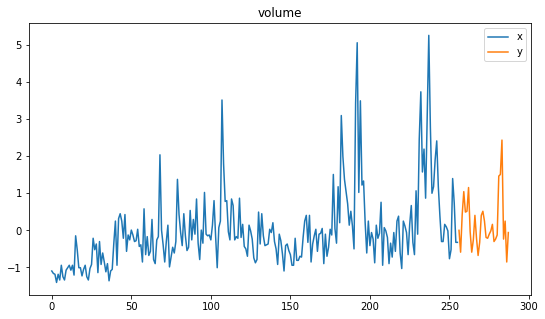

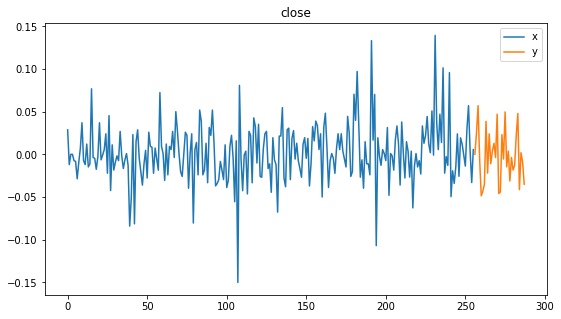

In [15]:
import matplotlib.pyplot as plt

n_seq = 269

src_len = X.shape[1]
tgt_len = y.shape[1]
plt.figure(figsize=(9, 5))
plt.plot(X[n_seq, :, 4], label = "x")
plt.plot([src_len + x for x in range(tgt_len)], y[n_seq, :, 4], label = "y")
plt.title("volume")
plt.legend()
plt.show()
plt.figure(figsize=(9, 5))
plt.plot(X[n_seq, :, 0], label = "x")
plt.plot([src_len + x for x in range(tgt_len)], y[n_seq, :, 0], label = "y")
plt.legend()
plt.title("close")
plt.show()

In [23]:
ciao = {}

def lol():
    ciao["ciao"] = "lol"
    ciao["ciao_2"] = "lol_2"
    pippo()

def pippo():
    ciao["ciao_2"] = "pippo_2"

lol()

ciao

{'ciao': 'lol', 'ciao_2': 'pippo_2'}

In [20]:
ciao

{'ciao': 'lol'}